# Visualising the Tellus stream sediment data
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](https://www.ausargeo.com))*

In this notebook I will plot the substance concentration maps produced by [my tellus_stream_sediment code](https://github.com/ar4/tellus_stream_sediment). This code uses the [Tellus](http://www.tellus.ie/) stream sediment data, and the [HydroSHEDS](http://hydrosheds.org/) flow directions data, to estimate the concentration of various substances in the areas of Ireland that have been sampled.

The Tellus project has released measurements of the concentration of various substances in stream sediment in Ireland and Northern Ireland. Only the coordinates of the sampling locations and the measurements are provided. For many users, such as mineral prospectors, it is the provenance - the location where these substances originated from - that is of interest. Although the data do not directly contain this information, if we combine them with estimates of where the stream water at each measurement location could have come from, we can infer the possible origins.

To do this, I use a flow directions map. This is a map that predicts the direction water will flow in at each point on the landscape. I can then determine the upstream area of each measurement point - the region of the landscape that drains through that point. Making some assumptions, including that all of the measured substance arrived at the measurement point by overland flow, I use this information to make a map of estimated substance concentration.

The README with my code has more details, including some additional discussion of the assumptions involved in this analysis.

To re-run this notebook, you must download `tellus_sediments.zip` (the download link is in [the code's README](https://github.com/ar4/tellus_stream_sediment)) and place it in the same directory as this notebook.

We then unzip the file, which contains the substance concentration GeoTIFFs.

In [8]:
!unzip tellus_sediments.zip

Archive:  tellus_sediments.zip
   creating: tellus_sediments/
  inflating: tellus_sediments/tellus_TiO2_%.tif  
  inflating: tellus_sediments/tellus_CaO_%.tif  
  inflating: tellus_sediments/tellus_Co_mgkg.tif  
  inflating: tellus_sediments/tellus_In_mgkg.tif  
  inflating: tellus_sediments/tellus_La_mgkg.tif  
  inflating: tellus_sediments/tellus_P2O5_%.tif  
  inflating: tellus_sediments/tellus_Zn_mgkg.tif  
  inflating: tellus_sediments/tellus_Sm_mgkg.tif  
  inflating: tellus_sediments/tellus_Ta_mgkg.tif  
  inflating: tellus_sediments/tellus_K2O_%.tif  
  inflating: tellus_sediments/tellus_Th_mgkg.tif  
  inflating: tellus_sediments/tellus_Hf_mgkg.tif  
  inflating: tellus_sediments/tellus_Cs_mgkg.tif  
  inflating: tellus_sediments/tellus_Sn_mgkg.tif  
  inflating: tellus_sediments/tellus_Nb_mgkg.tif  
  inflating: tellus_sediments/tellus_Ni_mgkg.tif  
  inflating: tellus_sediments/tellus_Ge_mgkg.tif  
  inflating: tellus_sediments/tellus_W_mgkg.tif  
  inflating: tellus_sedimen

To load these GeoTIFFs, I will use [GDAL](http://www.gdal.org/).

At the time of writing, the `pip install` approach doesn't work properly for me for GDAL, but `conda install` does (although even that requires specifying a particular version).

In [7]:
!conda install gdal basemap libgdal=2.0.0=0 krb5 -y

Fetching package metadata .........
Solving package specifications: .

Package plan for installation in environment /home/alanr/anaconda3:

The following NEW packages will be INSTALLED:

    krb5: 1.13.2-0

krb5-1.13.2-0. 100% |################################| Time: 0:00:01   2.00 MB/s


In [1]:
import os
import gdal
import gdalnumeric
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
%matplotlib inline

Now I will loop over the GeoTIFFs (there is one for each substance) and plot them. The title of each plot contains the name of the substance and the concentration units. I only plot a decimated version of the data (every 20th point in x and y) to reduce the computational load. To see the data in higher resolution, and be able to zoom in, you should open them with a GIS viewer as described in the README instructions with the code.

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


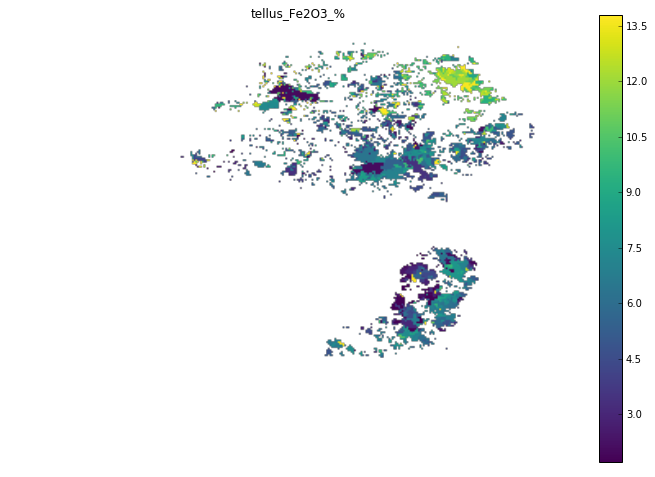

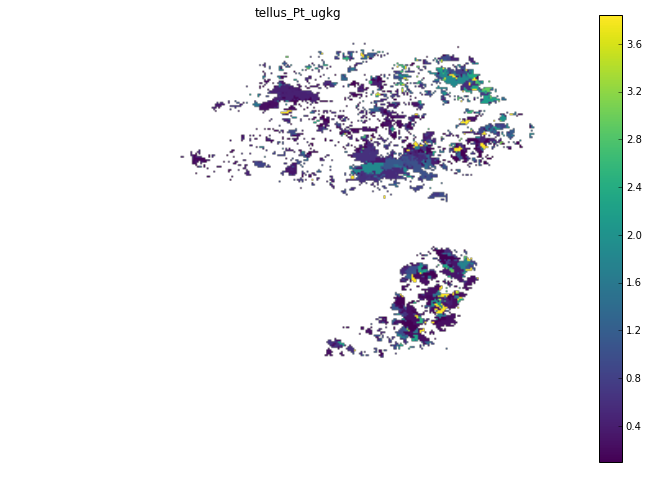

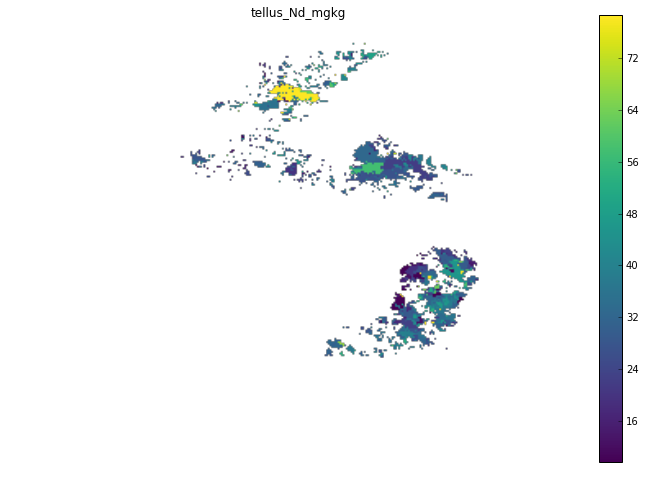

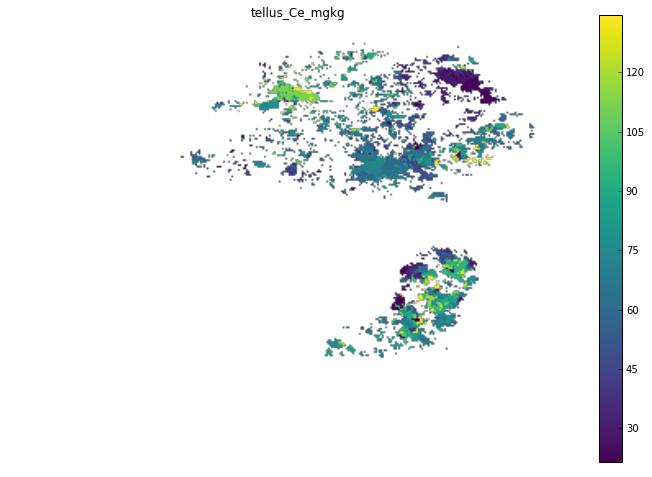

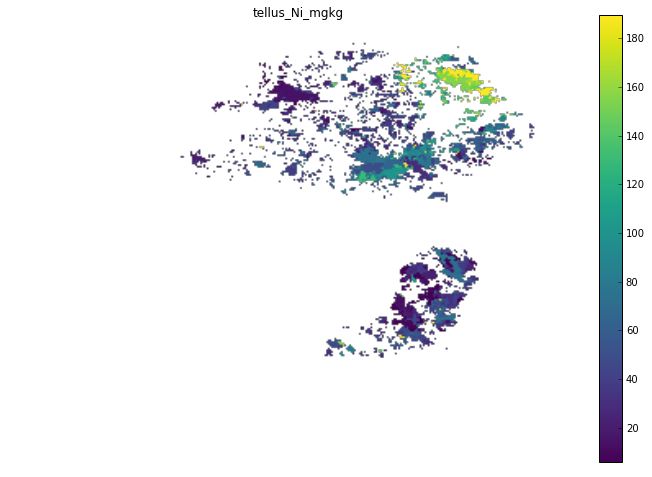

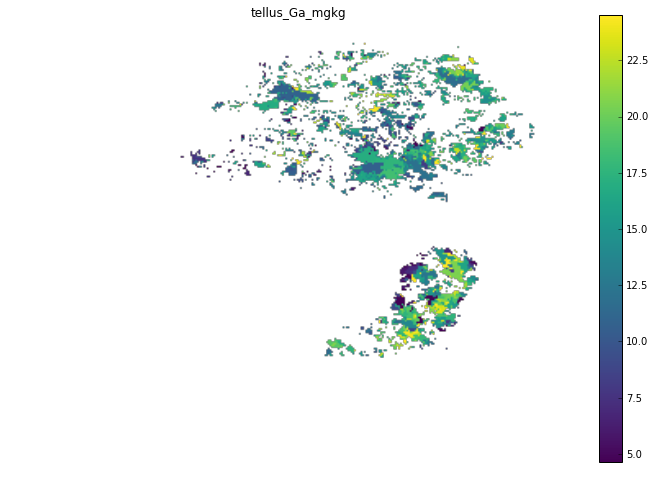

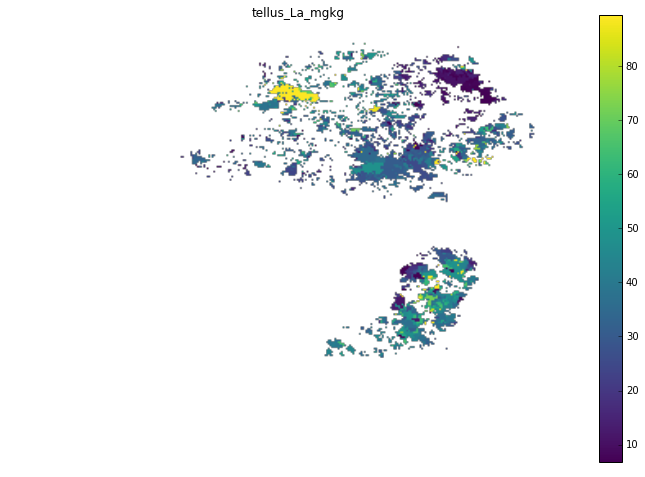

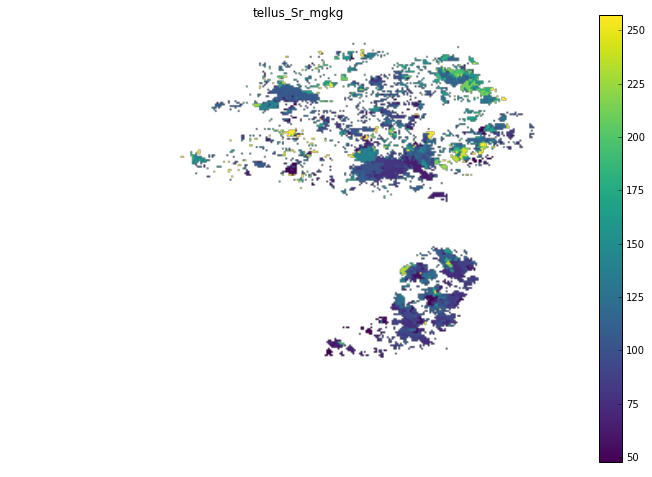

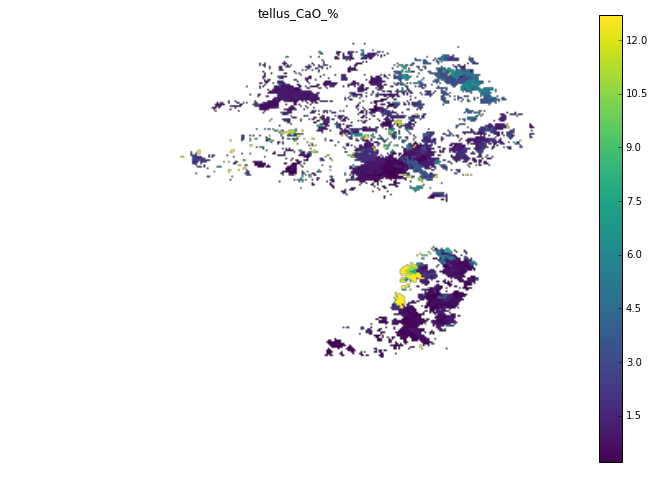

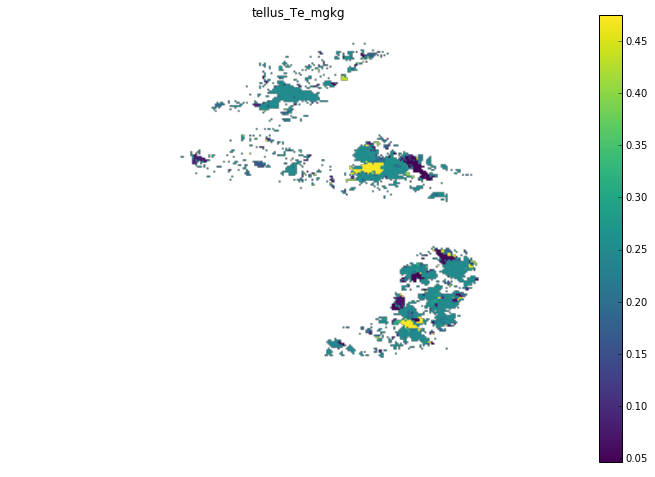

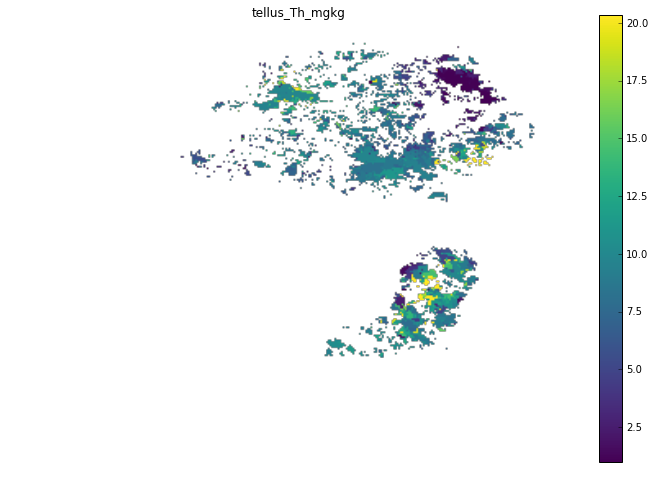

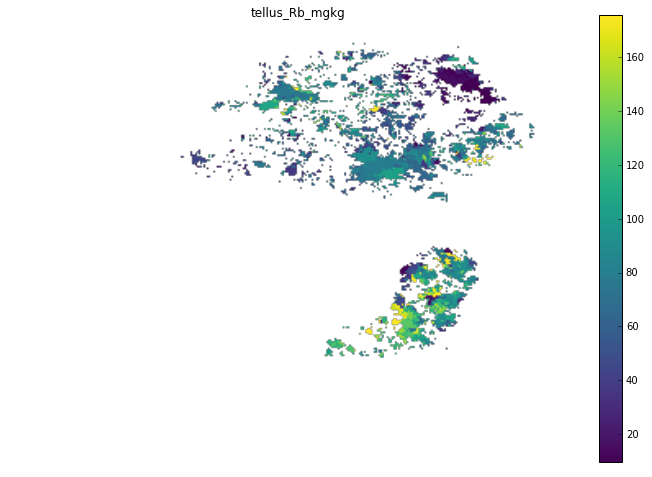

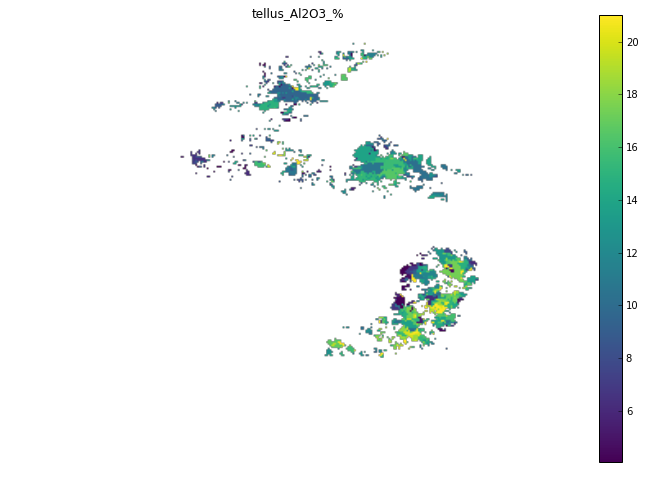

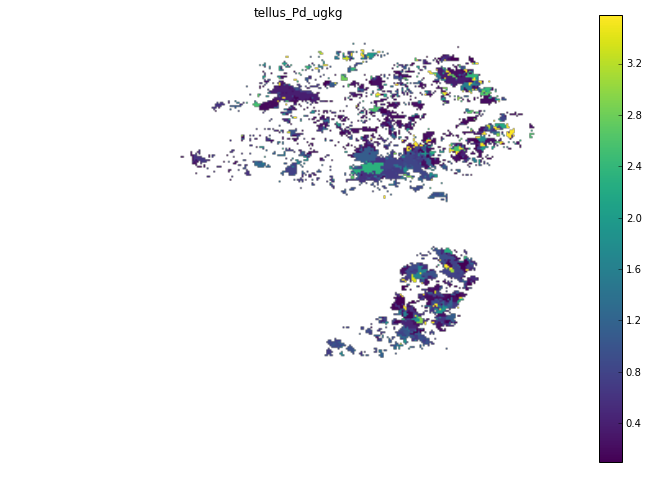

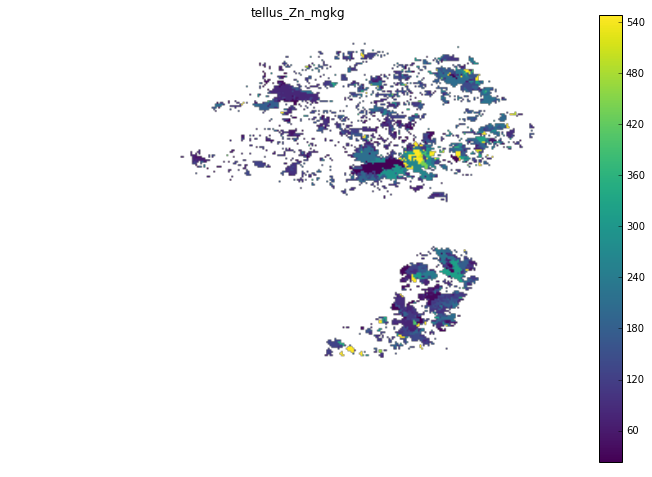

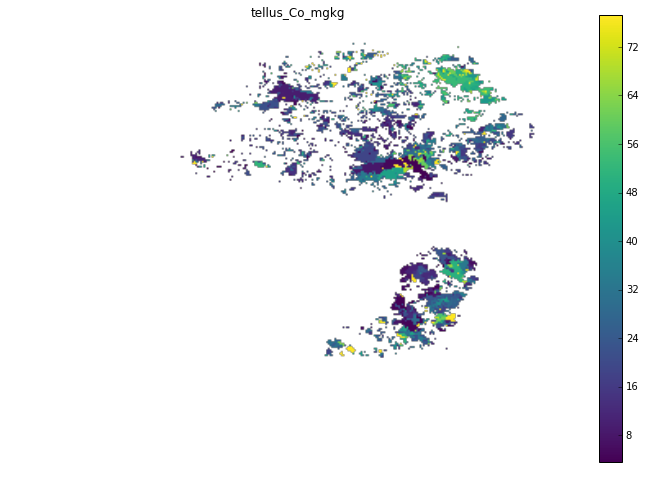

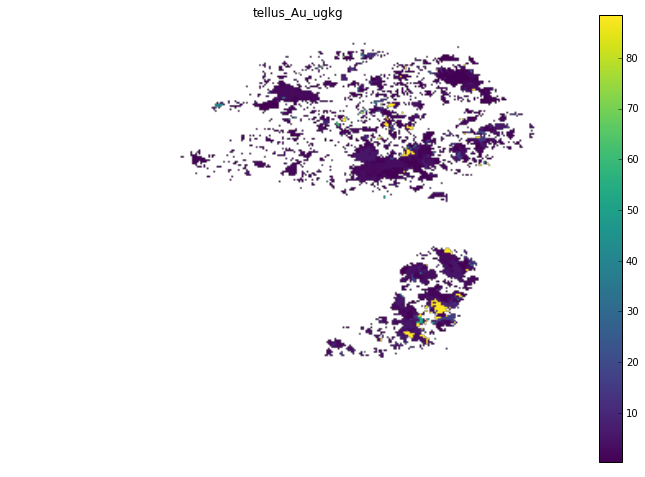

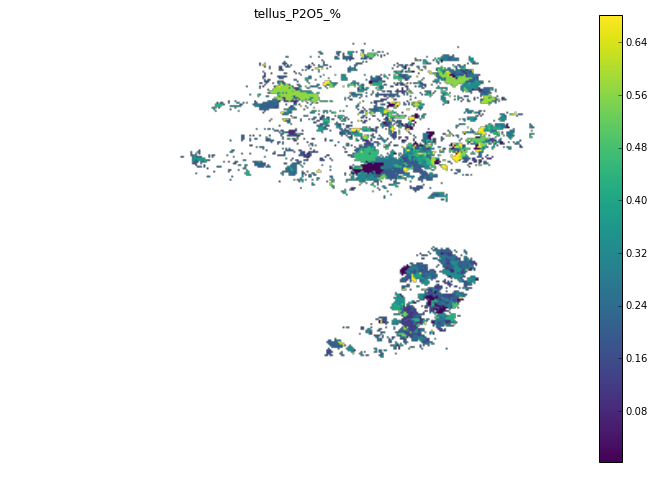

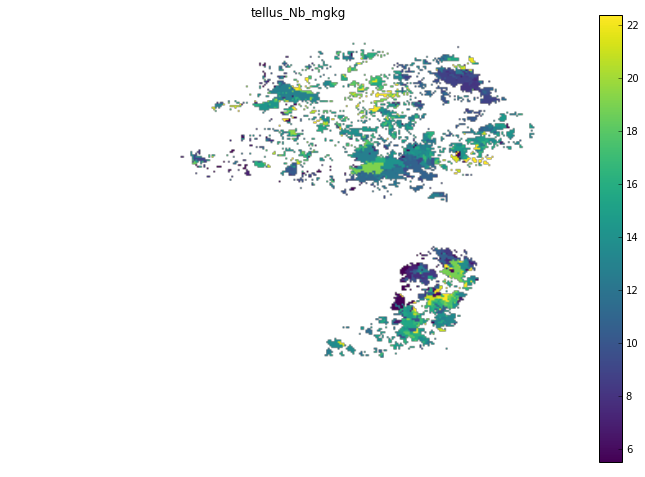

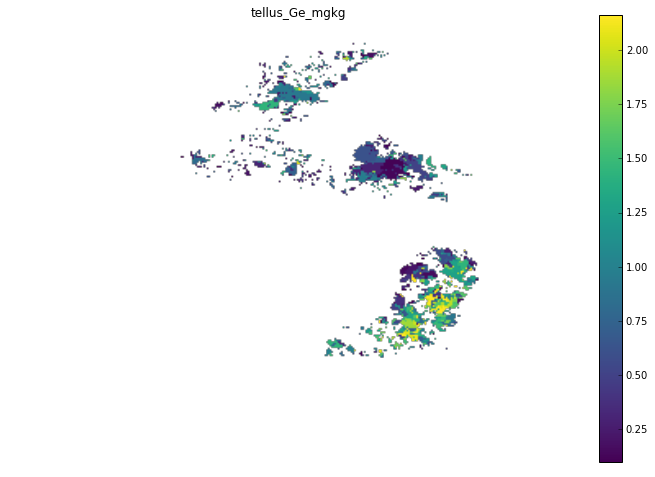

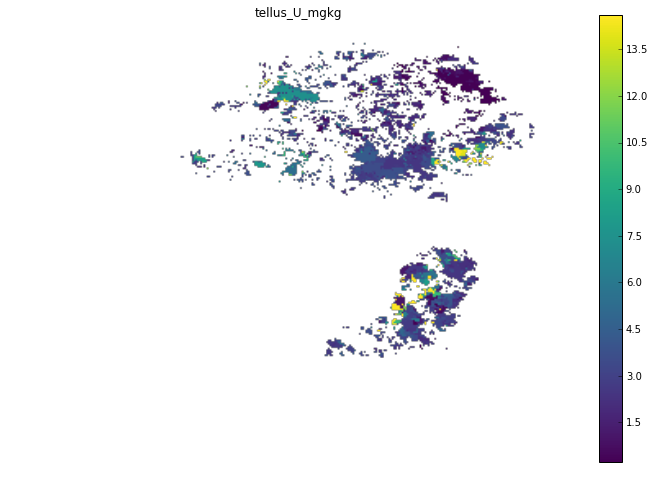

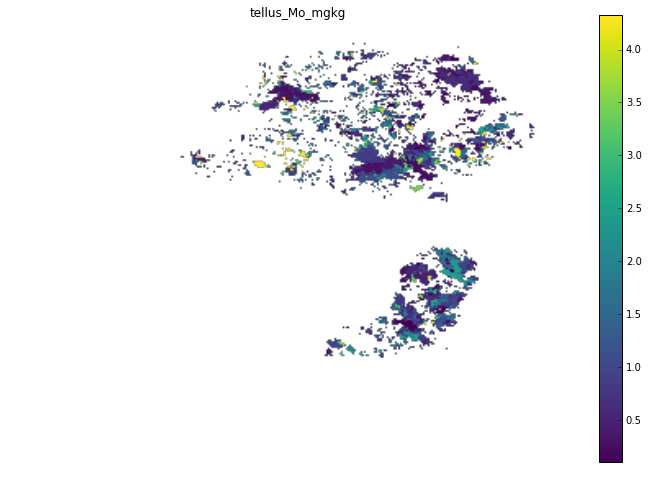

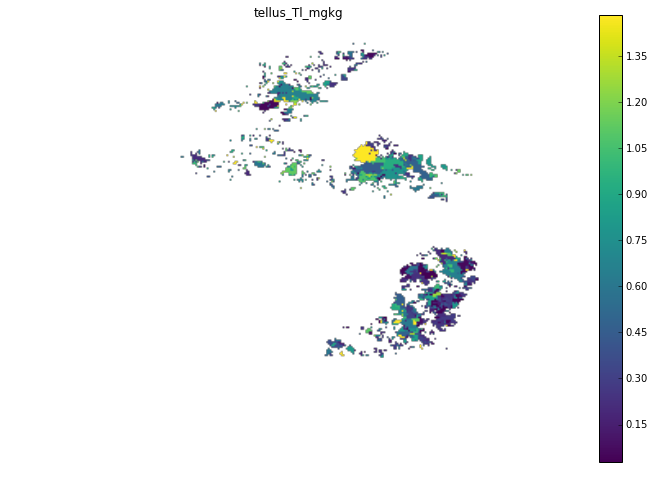

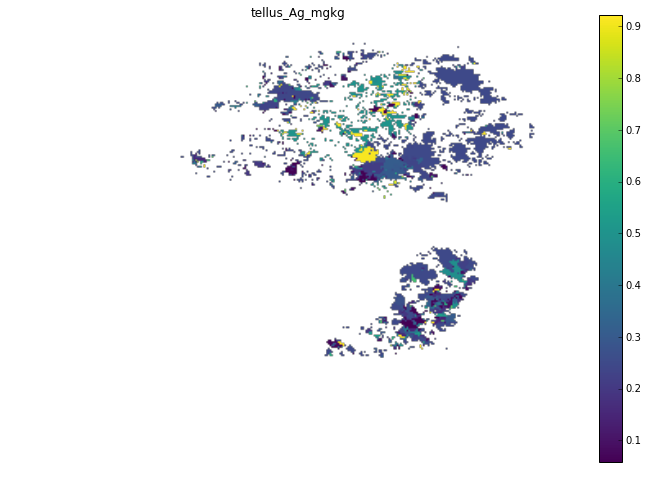

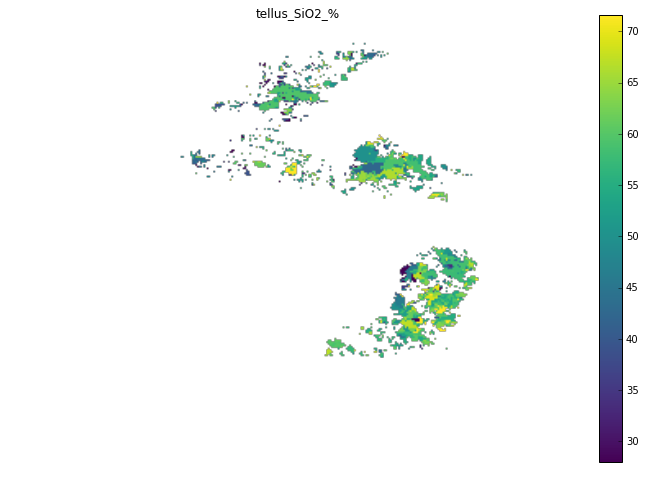

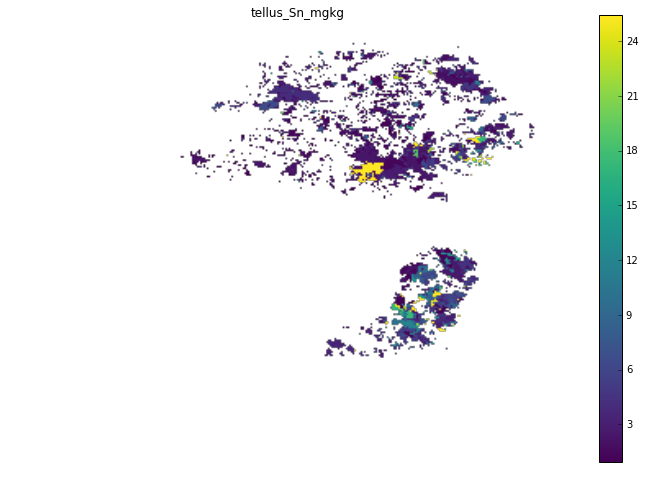

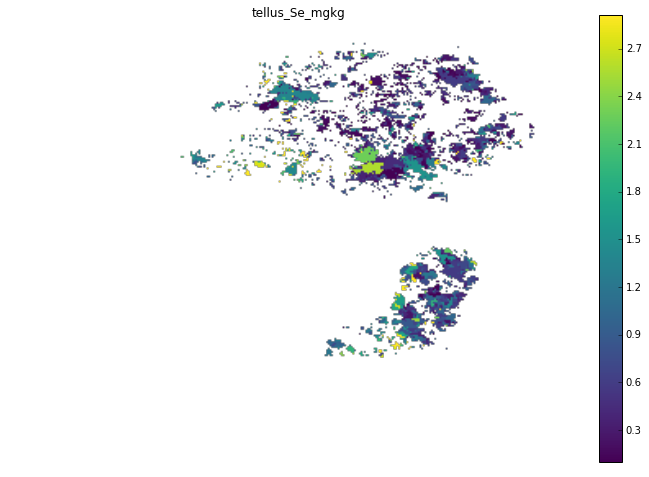

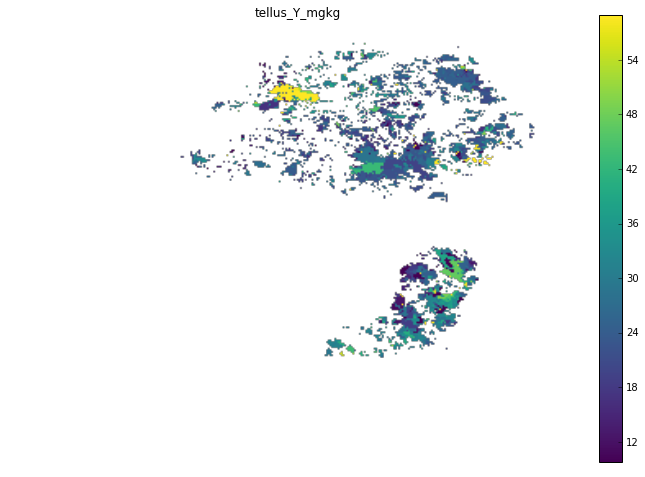

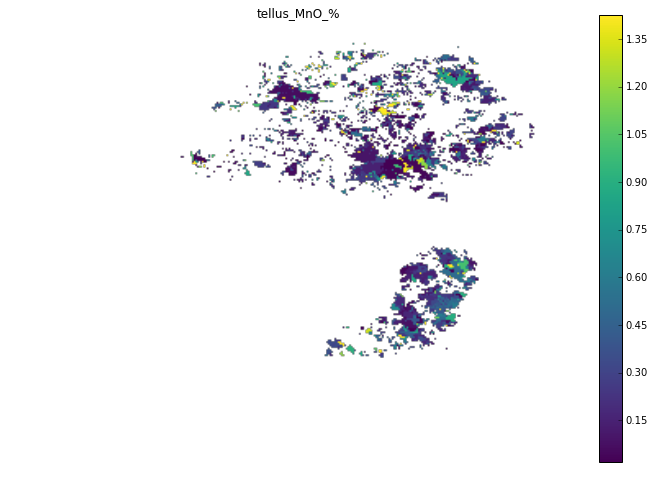

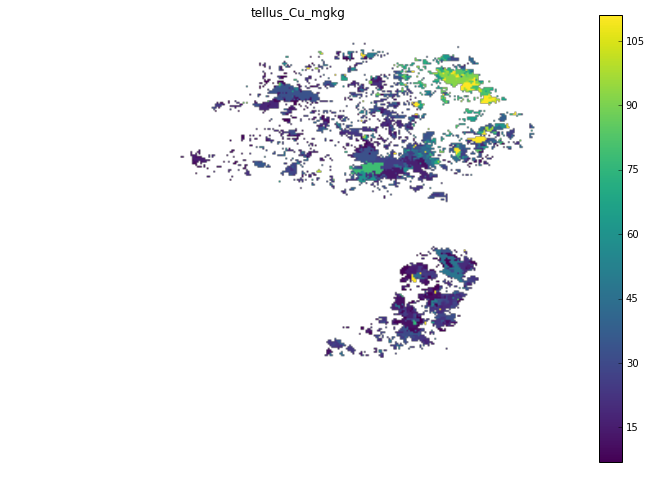

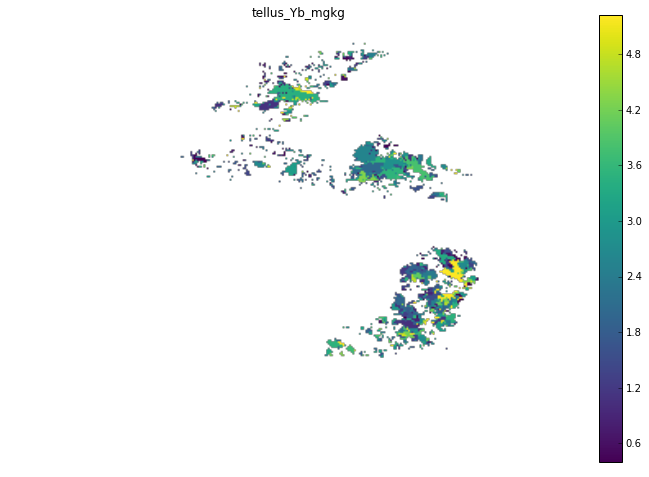

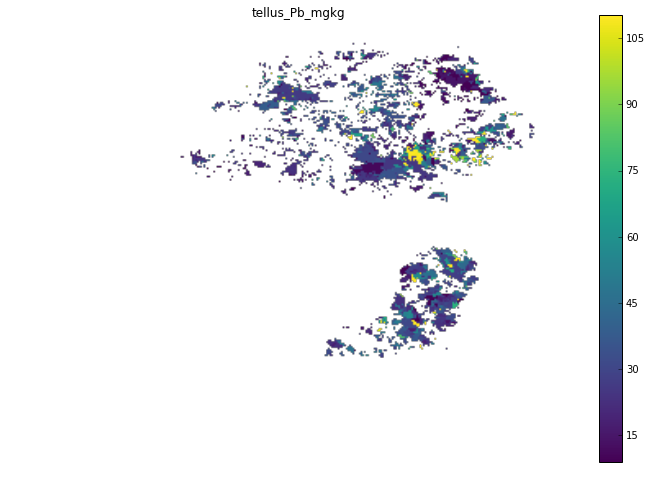

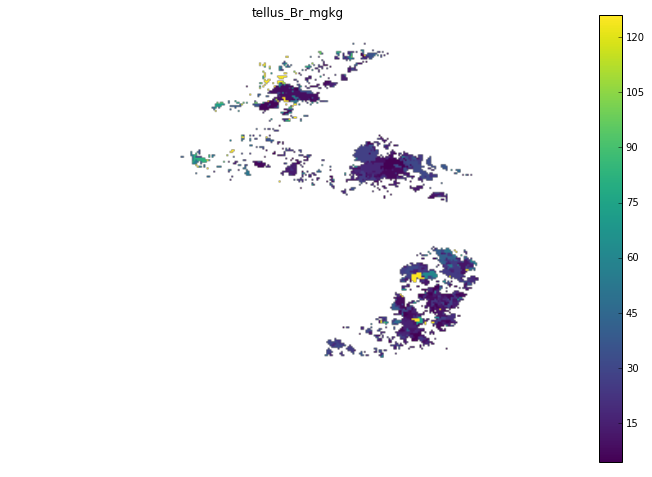

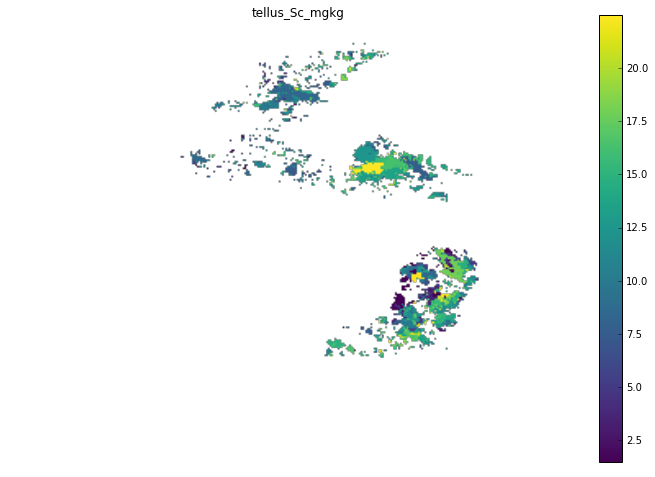

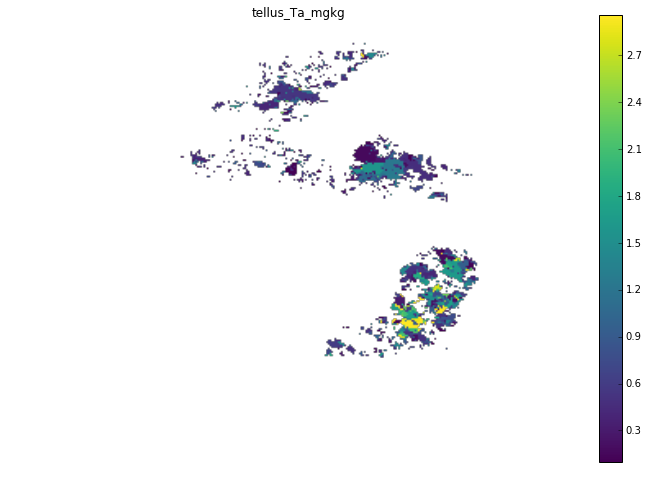

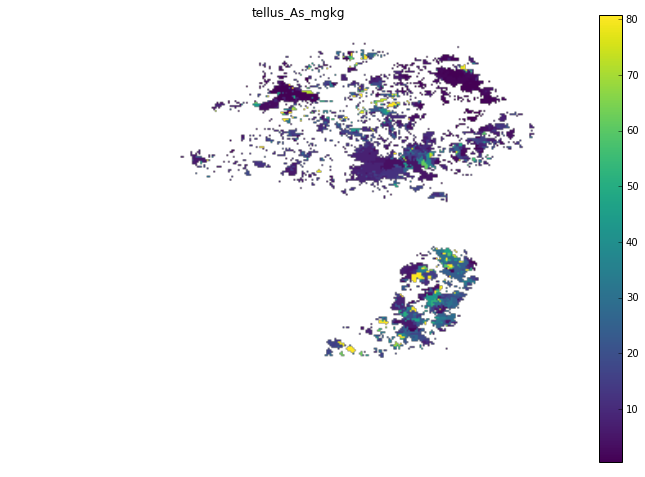

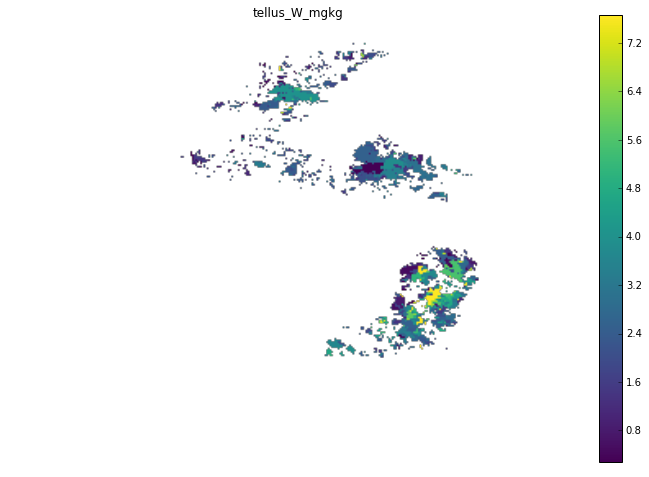

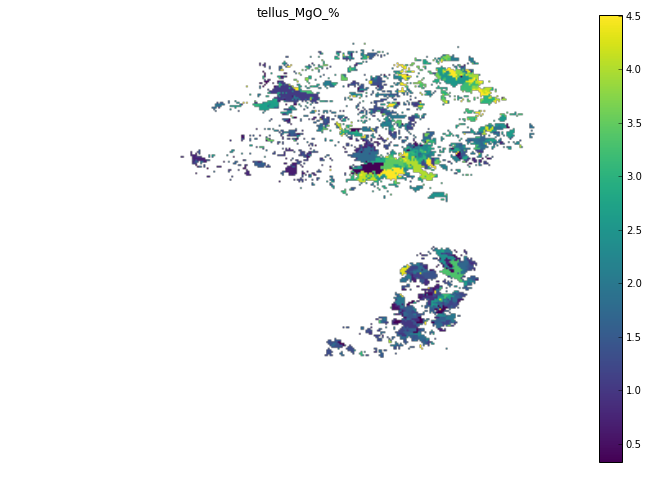

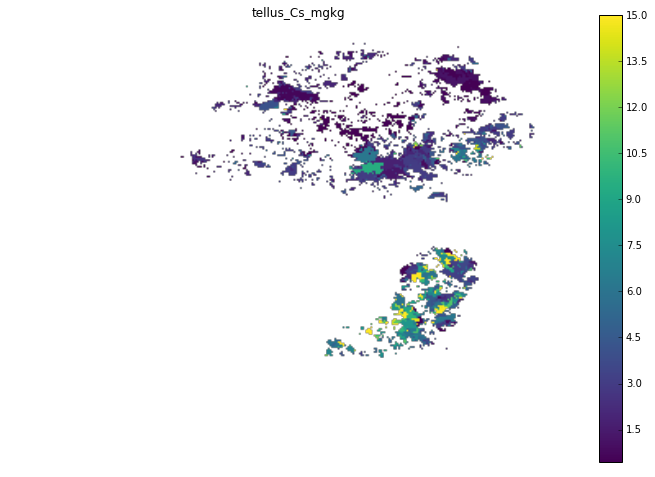

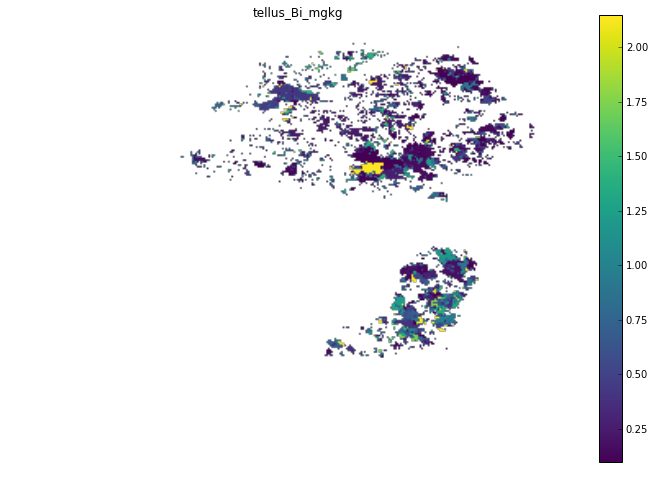

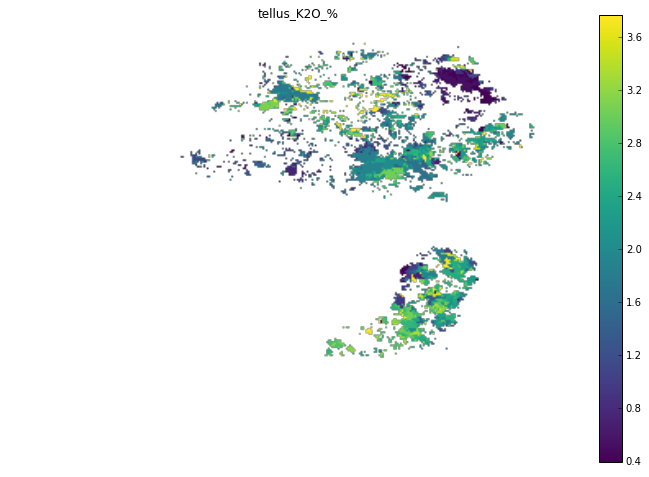

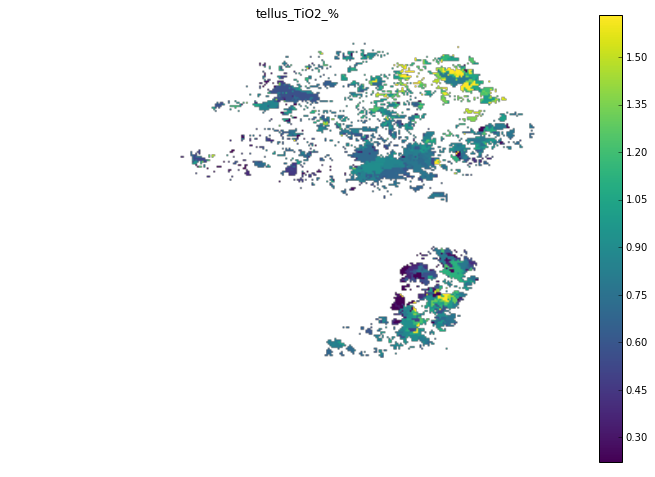

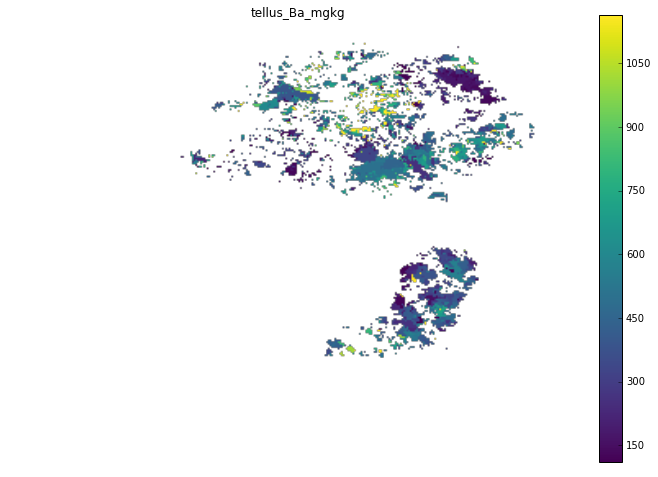

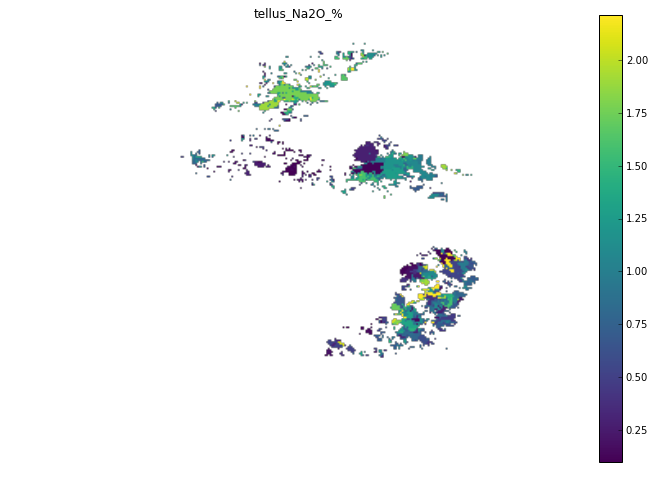

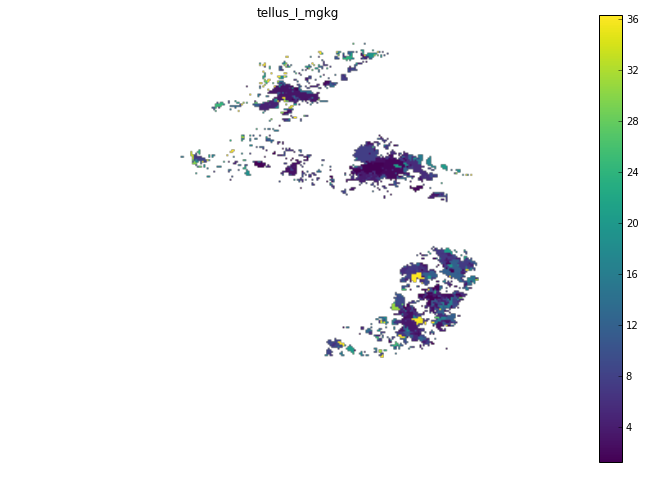

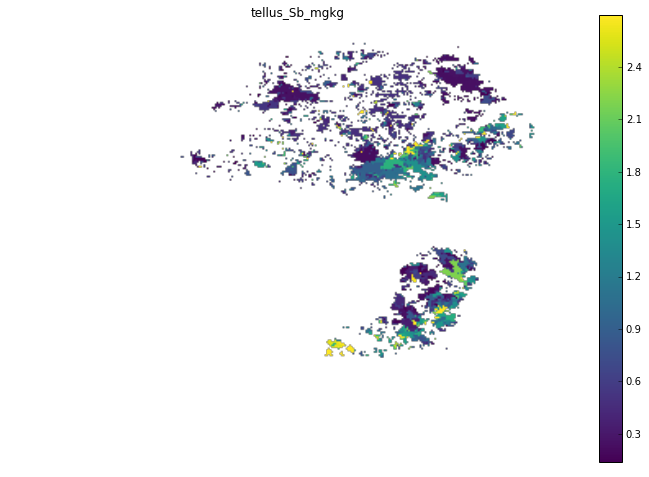

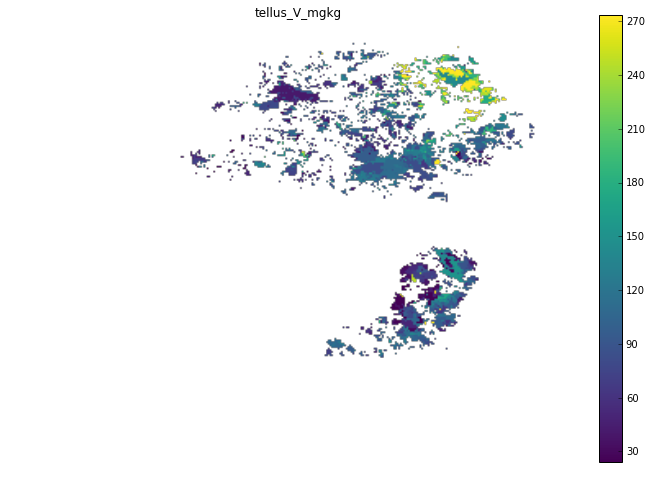

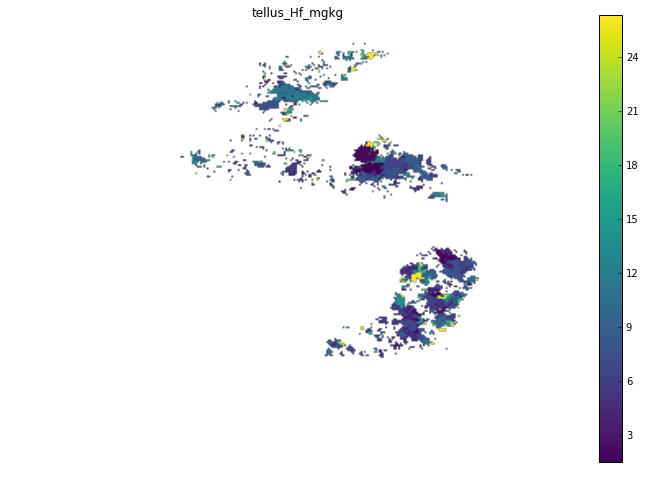

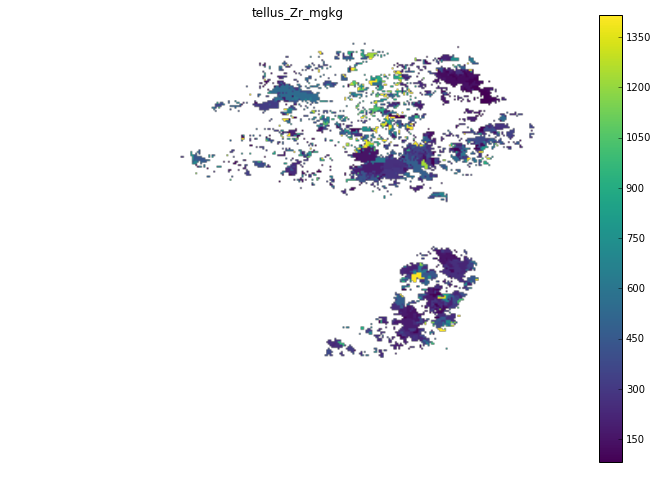

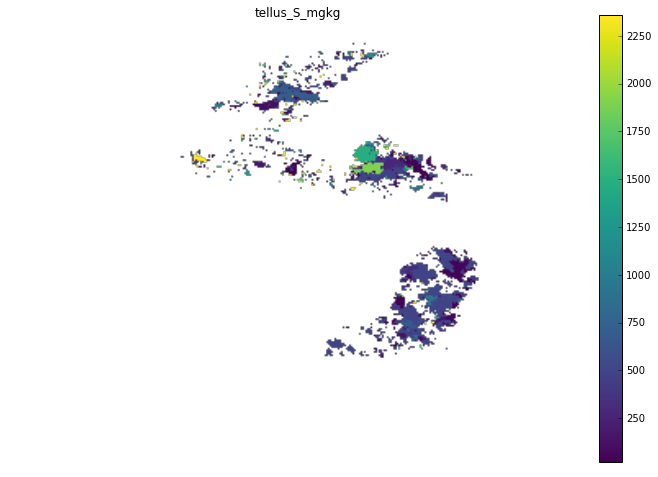

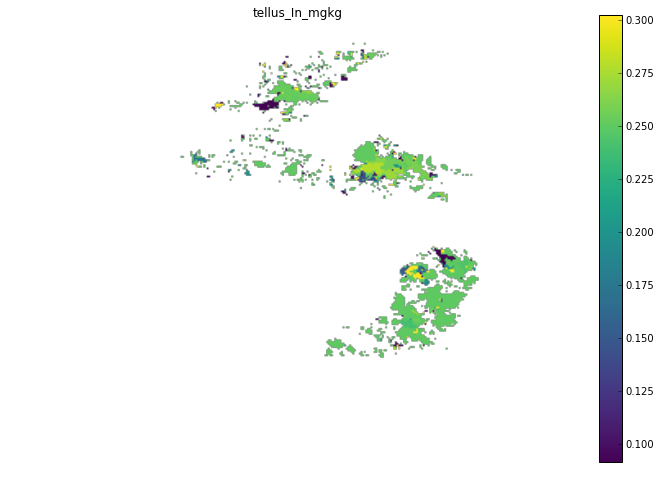

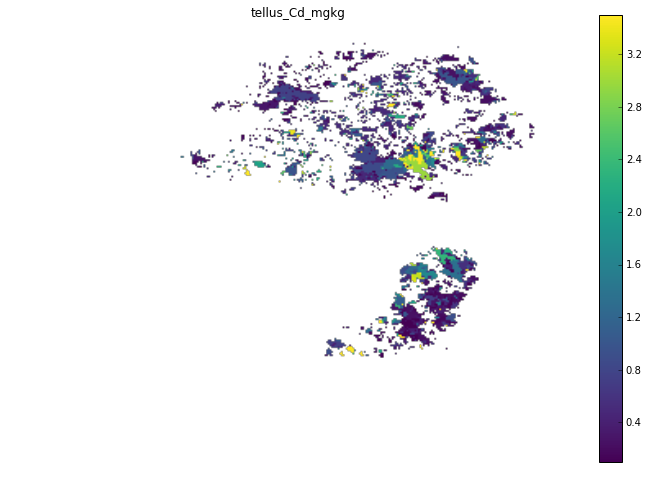

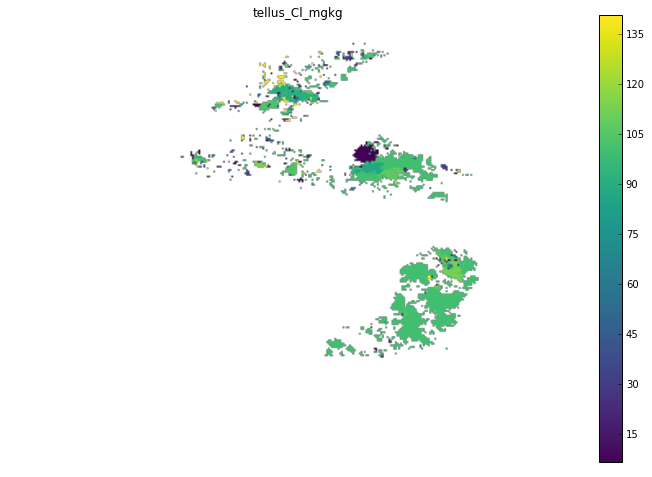

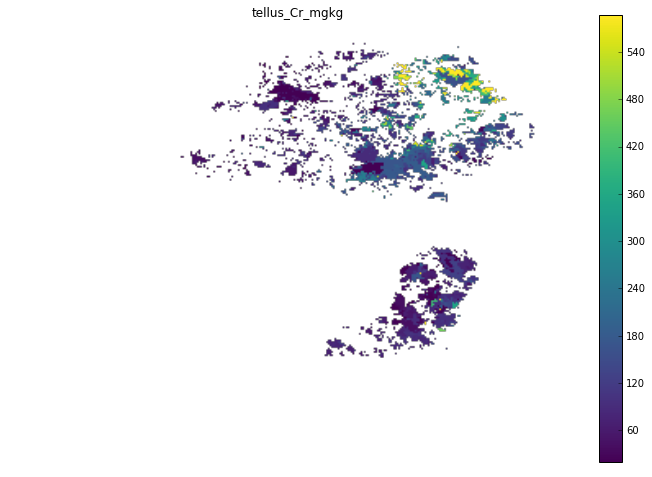

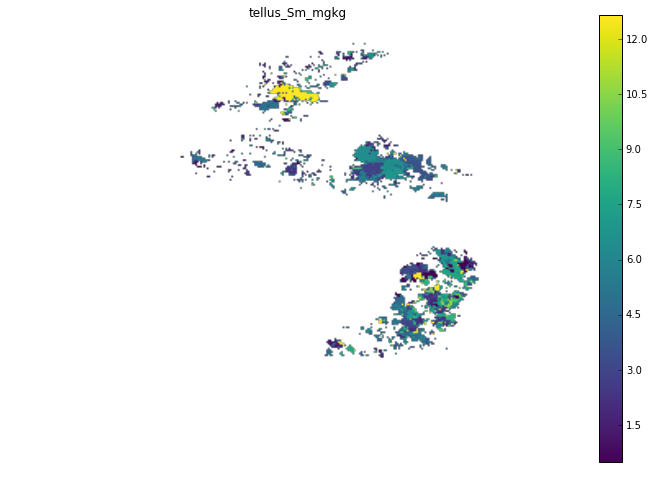

In [9]:
datadir = 'tellus_sediments'
for file in os.listdir(datadir):
    if file.endswith('.tif'):
        raster = gdalnumeric.LoadFile(os.path.join(datadir,file))
        name = os.path.splitext(file)[0]
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)
        ax.set_title(name)
        plt.axis('off')
        p = plt.imshow(raster[::20,::20], cmap='viridis',
                       vmin=np.nanpercentile(raster[::20,::20],3),
                       vmax=np.nanpercentile(raster[::20,::20],97))
        plt.colorbar(p)

## Comparing gold concentration with known occurrences

To investigate the accuracy of these concentration maps, we can compare the map of economic gold concentrations (> 0.5 ppm) with the list of known occurrences of gold contained in [Mineral Ireland's "Gold in Ireland" document](http://www.mineralsireland.ie/NR/rdonlyres/75C1CC8D-E889-4350-B657-BE9A3CCB6423/0/gold.pdf).

To do this, I first need to define a function to load the data and extract some coordinate information.

In [2]:
def get_raster_and_coords(raster_file):
    raster = gdal.Open(raster_file)
    raster_array = gdalnumeric.LoadFile(raster_file)
    geoTrans = raster.GetGeoTransform()
    pixel_width = geoTrans[1]
    pixel_height = geoTrans[5]
    left_X = geoTrans[0] + 0.5*pixel_width
    top_Y = geoTrans[3] + 0.5*pixel_height
    right_X = left_X + (raster_array.shape[1]-1) * pixel_width
    bottom_Y = top_Y + (raster_array.shape[0]-1) * pixel_height
    llcrnrlon = left_X
    llcrnrlat = bottom_Y
    urcrnrlon = right_X
    urcrnrlat = top_Y
    return raster_array, llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat

Now I define the path to the file with the gold concentration map that I produced with my code.

In [3]:
au_file = 'tellus_sediments/tellus_Au_ugkg.tif'

I also make an array with the coordinates of the locations noted in "Gold in Ireland". Since Tellus doesn't cover all of Ireland yet, I only include those points that are within the current survey area. This excludes points near Croagh Patrick, and also the vague "Co. Kildare".

In [4]:
au_locs = [[54.215356, -6.853319, 'Clontibret'],
[54.689, -7.079, 'Greencastle'],
[52.709, -6.495, 'Carnew'],
[54.586389, -6.903333, 'Cavanacaw'],
[52.895064, -6.187536, 'Kilmacoo']]

Calling the function I defined above returns the gold concentration map array, `au`, and the coordinates of the lower left and upper right corners of the map.

In [13]:
au, llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat = get_raster_and_coords(au_file)

I decimate it a bit to make it more manageable.

In [14]:
au = au[::5,::5]

I can now plot the concentration map, with the points overlaid. To make the relevant parts of the concentration map easier to see, I only show whether or not the estimated gold concentration is greater than 500 micrograms/kilogram (0.5 ppm).

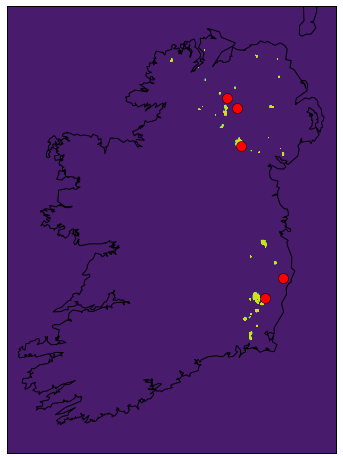

In [16]:
lat_0 = (llcrnrlat + urcrnrlat)/2
lon_0 = (llcrnrlon + urcrnrlon)/2

fig = plt.figure(figsize=(12,8))
au_map = Basemap(projection='tmerc', lat_0=lat_0, lon_0=lon_0,
                 resolution='i', area_thresh=1000.0, llcrnrlon=llcrnrlon,
                 llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)
 
au_map.drawcoastlines()

x = np.linspace(0, au_map.urcrnrx, au.shape[1])
y = np.linspace(au_map.urcrnry, 0, au.shape[0])

xx, yy = np.meshgrid(x, y)

high_au = au>500
au_map.contourf(xx, yy, high_au, cmap='viridis')

lons = [c[1] for c in au_locs]
lats = [c[0] for c in au_locs]
x,y = au_map(lons, lats)
au_map.plot(x, y, 'ro', markersize=10)
 
plt.show()

There does appear to be a fairly good correlation between the two. It also looks like there are several locations worth investigating!

Despite the confidence that this result inspires, I think it would still be wise to be cautious about the concentration maps. The assumptions involved in their construction provide many opportunities for errors. I plan to update this notebook each time new Tellus data is released, and may also refine the model to reduce some possible sources of error at the same time.